In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from analyze_results_functions import *
import prim
%matplotlib inline

### load data

In [2]:
cba_no_flood = read_csv("data_cba/cba_no_flood_million_rs_per_ha.csv")
flood_losses = read_csv("data_cba/all_economic_losses_2013.csv")
urban_outputs = pd.read_csv("data_cba/results_uncertainty_urban.csv",sep=",")
urban_inputs = pd.read_csv("data_cba/urban_uncertainty_matrix_sept14.csv")

### additional data

In [3]:
ppp_to_rupee = 45.35

In [5]:
paolo_gdp_pc_rupee = 77723*12
jc_gdp_pc_ppp = 178330.6078

In [6]:
paolo_gdp_pc_rupee/jc_gdp_pc_ppp

5.230038811094099

In [7]:
total_ha = 2300*10**(-3)
ini_pop=2.3*10**6
gdp_2013=ini_pop*gdp_per_capita_2013
resilience = 0.66

In [8]:
gdp_per_capita_2013/paolo_gdp_pc_rupee

0.8210275201225425

### reformat data

In [6]:
cba_no_flood[['min','max']]=cba_no_flood[['min','max']]*total_ha

In [7]:
flood_losses["wetland_preserv"]=100-flood_losses["wetland_loss"]

In [8]:
flood_losses["costpcGDP"]=flood_losses.annuallosses*10**9/gdp_2013

In [12]:
urban_outputs.sample(3)

,utility_no_excl,utility_excl,var_rent_tot(%),var_foncier_tot(%),income_equi(RS),info_solve_model_no_excl,info_solve_model_no_excl.1,info_solve_equi,Unnamed: 8
416,23676.70,23676.70,0.000000,NaN,0.0000,-2,-2,1,NaN
653,20939.73,20715.55,1.394080,6.708496,10959.8700,1,1,1,NaN
319,410888.60,410785.90,0.009096,1.238125,232.3398,1,1,1,NaN


In [13]:
urban_inputs.sample(3)

,coeff_b,coeff_beta,coeff_land_max,land_recycl,time_cost,coeff_grandA
715,0.528337,0.136400,0.437413,0.160187,0.700161,16.245348
857,0.445408,0.284312,0.685816,0.300796,0.413270,28.554433
926,0.459305,0.183392,0.719596,0.716619,1.446970,3.862263


In [14]:
flood_losses.sample(3)

,GDPgr,Popgr,losses_share,urban_policy,scenario_number,wetland_loss,climate_change,runoff,bndconditions,annuallosses
137,0,0,0.07,0,46,50,1,0.6,1,8.532834
233,0,0,0.10,0,52,50,2,0.6,1,14.292592
82,0,0,0.05,0,81,100,1,0.6,0,5.702117


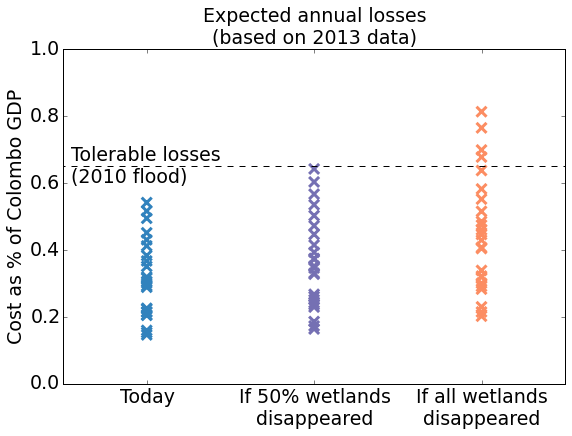

In [17]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(9,6))

ax=plt.subplot(111)

ax.fill_between([0,4], 1, 3,facecolor='blue',alpha=0.05)

select = (losses.wetland_preserv==100)&(losses.climate_change==0)
y1=100*losses.ix[select,"costpcGDP"]
plt.scatter([1]*len(y1),y1,marker='x',facecolors='none',edgecolors='#3182bd',linewidth='3',s=100,alpha=1)
select2 = (losses.wetland_preserv==50)&(losses.climate_change==0)
y2=100*losses.ix[select2,"costpcGDP"]
plt.scatter([2]*len(y2),y2,marker='x',facecolors='none',edgecolors='#7570b3',linewidth='3',s=100,alpha=1)
select2 = (losses.wetland_preserv==0)&(losses.climate_change==0)
y2=100*losses.ix[select2,"costpcGDP"]
plt.scatter([3]*len(y2),y2,marker='x',facecolors='none',edgecolors='#fc8d62',linewidth='3',s=100,alpha=1)



plt.xticks([1,2,3])
aa = ["Today", "If 50% wetlands\ndisappeared","If all wetlands\ndisappeared"]
ax.set_xticklabels(aa)

plt.plot([0,4],[1*0.65]*2,color="black",linestyle='--')
plt.annotate('Tolerable losses\n(2010 flood)', xy=(0.55, 0.6))


plt.title("Expected annual losses\n(based on 2013 data)",fontsize=19)

plt.ylabel("Cost as % of Colombo GDP")

ax.set_xlim([0.5,3.5])
ax.set_ylim([0.,1])

plt.savefig("report/expected_losses_today_fb12.png",bbox_inches="tight",dpi=100)

In [18]:
select = (losses.climate_change<2)&(losses.wetland_preserv==0)
sousgroup = losses.ix[select,:].copy()
experiments=sousgroup[['losses_share','climate_change', 'runoff',\
                      'bndconditions']].copy()
outcomes=sousgroup[['costpcGDP']].copy()
outcomes['neg']=0+(outcomes['costpcGDP']>0.01)

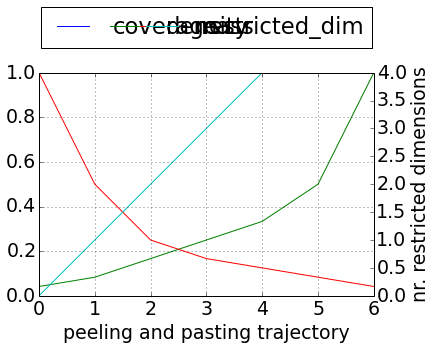

In [19]:
forprim=format_data(outcomes,experiments,"neg")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [22]:
box.inspect(6)

coverage    1.000000
density     1.000000
mass        0.041667
mean        1.000000
res dim     4.000000
Name: 6, dtype: float64

               box 6                
                 min   max qp values
losses_share    0.11  0.12  0.062500
bndconditions   0.50  1.00  0.250000
climate_change  0.50  1.00  0.250000
runoff          0.45  0.60  0.444444



In [14]:
indx1 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', \
                                'climate_change', 'runoff', 'bndconditions']
indx2 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', 'wetland_preserv', \
                                'climate_change', 'runoff', 'bndconditions']

In [15]:
c = (losses.drop("scenario_number",axis=1).query('wetland_preserv>0').set_index(indx1) - \
 losses.drop("scenario_number",axis=1).query('wetland_preserv==0').set_index(indx1)).reset_index().set_index(indx2).rename(columns={"annuallosses":"diffannuallosses"})

new_losses = concat([losses.set_index(indx2),-c],axis=1).reset_index().fillna(0)

In [16]:
new_losses.ix[new_losses.wetland_preserv==100,"diffannuallosses"].describe()

count    72.000000
mean      3.409753
std       1.544519
min       0.984479
25%       2.210903
50%       2.988932
75%       4.316906
max       7.159197
Name: diffannuallosses, dtype: float64

In [48]:
endyear=2020

In [50]:
npv=DataFrame()
bl_min = cba.ix[cba.option=="land","min"].values
bl_max = cba.ix[cba.option=="land","max"].values
for option in ['wetland with no recreation', 'wetland with recreation', 'lake']:
    npv_temp = new_losses.copy()
    cb_min = cba.ix[cba.option==option,"min"].values
    cb_max = cba.ix[cba.option==option,"max"].values
    for cb in [cb_min,(cb_min+cb_max)/2,cb_max]:
        for bl in [bl_min,(bl_min+bl_max)/2,bl_max]:
            npv_temp["benef"] = npv_temp.diffannuallosses+1/100*npv_temp.wetland_preserv*\
                               cb*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
            npv_temp["cost"] = 1/100*npv_temp.wetland_preserv*\
                               bl*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
            npv_temp["npv"]   = npv_temp["benef"]-npv_temp["cost"]
            npv_temp.ix[:,"option"] = option
            npv_temp.ix[:,"cb"] = cb
            npv_temp.ix[:,"bl"] = bl
            npv = npv.append(npv_temp)

In [51]:
npv_res=DataFrame()
bl_min = cba.ix[cba.option=="land","min"].values
bl_max = cba.ix[cba.option=="land","max"].values
for option in ['wetland with no recreation', 'wetland with recreation', 'lake']:
    npv_temp = new_losses.copy()
    cb_min = cba.ix[cba.option==option,"min"].values
    cb_max = cba.ix[cba.option==option,"max"].values
    for cb in [cb_min,(cb_min+cb_max)/2,cb_max]:
        for bl in [bl_min,(bl_min+bl_max)/2,bl_max]:
            for sh_soc in [0.5,1]:
                npv_temp["benef"] = npv_temp.diffannuallosses/0.65+1/100*npv_temp.wetland_preserv*\
                               cb*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
                npv_temp["cost"] = sh_soc*1/100*npv_temp.wetland_preserv*\
                               bl*((1+npv_temp.Popgr)**(endyear-2013)*(1+npv_temp.GDPgr)**(endyear-2013))
                npv_temp["npv"]   = npv_temp["benef"]-npv_temp["cost"]
                npv_temp.ix[:,"option"] = option
                npv_temp.ix[:,"cb"] = cb
                npv_temp.ix[:,"bl"] = bl
                npv_temp.ix[:,"sh_soc"] = sh_soc
                npv_res = npv_res.append(npv_temp)

In [52]:
indx3 = ['GDPgr', 'Popgr', 'losses_share', 'urban_policy', 'wetland_preserv', \
                                'climate_change', 'runoff', 'bndconditions','option','cb','bl','sh_soc']

In [53]:
jojo=npv_res.set_index(indx3).npv.unstack("wetland_preserv")
zz = jojo.apply(lambda s:s-jojo.max(axis=1))
regret = zz.stack().reset_index().rename(columns={0:"regret"})

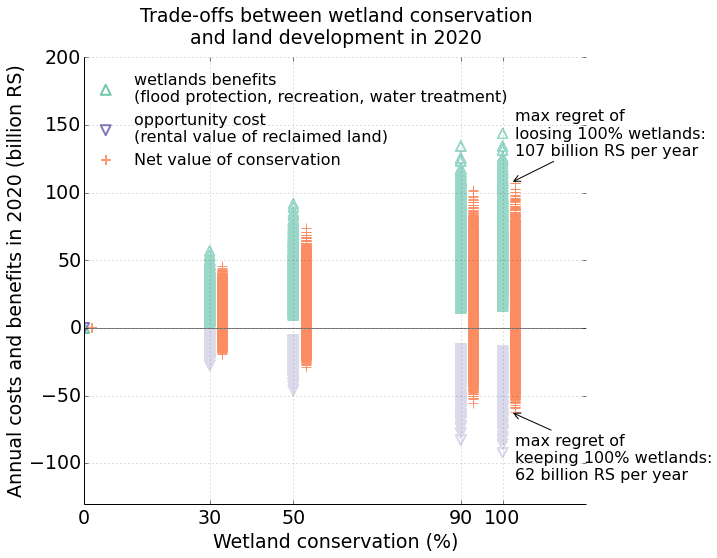

In [151]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(9,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change==1)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="opportunity cost\n(rental value of reclaimed land)")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.37,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)+3]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
       
    
    if i==4:
        ax.annotate("max regret of\nkeeping {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-50), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"),fontsize=16)
        
        ax.annotate("max regret of\nloosing 100% wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+20), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                    fontsize=16
                    )
        
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Trade-offs between wetland conservation\nand land development in 2020",\
         y=1.02,fontsize=19)

plt.savefig("min_max_regret_wetlands_rev.png",bbox_inches="tight",dpi=400)

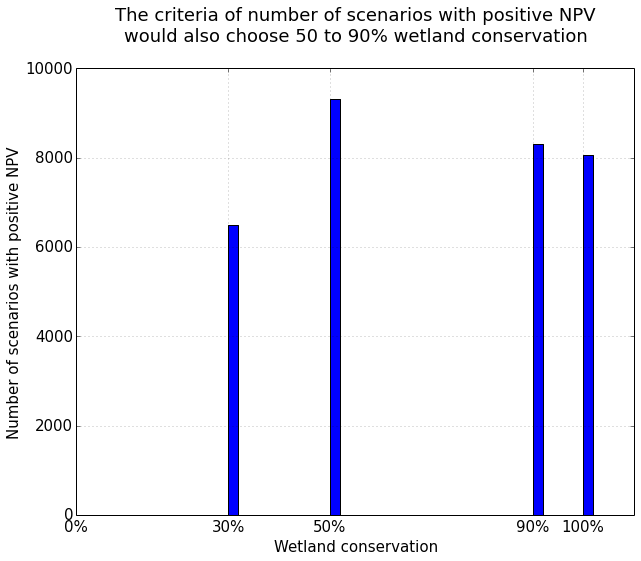

In [72]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

#select = (npv_res.option=="wetland with recreation")
select = (npv_res.urban_policy==0)&(npv_res.climate_change<2)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

for i, (name, group) in enumerate(grouped):
    y1 = sum(group.npv>0)
    plt.bar(int(name),y1,width=2)
    
ax.grid(which='major', alpha=0.5)

plt.xticks([0,30,50,90,100])
aa = ["{}%".format(i) for i in [0,30,50,90,100]]
ax.set_xticklabels(aa)

plt.ylabel('Number of scenarios with positive NPV')
plt.xlabel('Wetland conservation')

plt.title("The criteria of number of scenarios with positive NPV\nwould also choose 50 to 90% wetland conservation",y=1.05)

In [112]:
from lib_for_prim import *

In [142]:
select = (npv_res.urban_policy==0)&(npv_res.climate_change<2)&(npv_res.option=="wetland with recreation")&\
(npv_res.wetland_preserv==30)
sousgroup = npv_res.ix[select,:].copy()
experiments=sousgroup[['GDPgr', 'Popgr', 'losses_share','climate_change', 'runoff',\
                      'bndconditions','cb','bl','sh_soc']].copy()
outcomes=sousgroup[['npv']].copy()
outcomes['pos']=0+(outcomes['npv']>0)
outcomes['neg']=0+(outcomes['npv']<0)

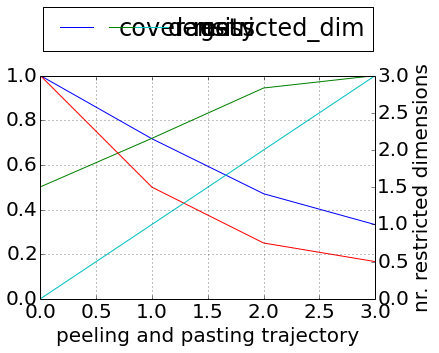

In [143]:
forprim=format_data(outcomes,experiments,"pos")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [144]:
box.inspect(1)

coverage    0.716923
density     0.719136
mass        0.500000
mean        0.719136
res dim     1.000000
Name: 1, dtype: float64

               box 1                   
                 min max      qp values
climate_change   0.5   1  2.375730e-278



In [139]:
experiments.describe()

,GDPgr,Popgr,losses_share,climate_change,runoff,bndconditions,cb,bl,sh_soc
count,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.00000
mean,0.040000,0.015000,0.400000,0.500000,0.500000,0.500000,12.650000,39.100000,0.75000
std,0.028285,0.011181,0.163306,0.500019,0.081653,0.500019,4.695036,3.756029,0.25001
min,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,6.900000,34.500000,0.50000
25%,0.020000,0.007500,0.200000,0.000000,0.400000,0.000000,6.900000,34.500000,0.50000
50%,0.040000,0.015000,0.400000,0.500000,0.500000,0.500000,12.650000,39.100000,0.75000
75%,0.060000,0.022500,0.600000,1.000000,0.600000,1.000000,18.400000,43.700000,1.00000
max,0.080000,0.030000,0.600000,1.000000,0.600000,1.000000,18.400000,43.700000,1.00000


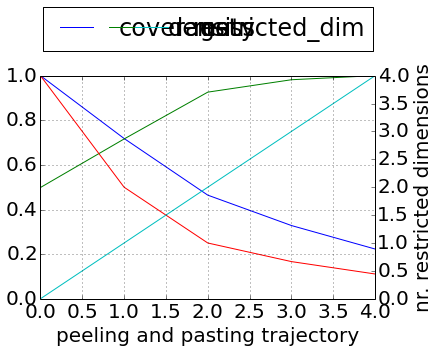

In [145]:
forprim=format_data(outcomes,experiments,"neg")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [146]:
box.inspect(1)

coverage    0.718266
density     0.716049
mass        0.500000
mean        0.716049
res dim     1.000000
Name: 1, dtype: float64

               box 1                    
                 min  max      qp values
climate_change     0  0.5  8.227707e-278



In [44]:
compare = read_csv("data_cba/lakes-vs-wetlands.csv")

In [45]:
compare = compare.set_index("Unnamed: 0")
compare.index = [s.replace(" ","\n") for s in compare.index]

In [49]:
comparer = np.round(compare/144,2)
comparer

,wetland with recreation,wetland,lake with recreation,lake with no recreation
Construction\nmaintenance,-0.07,0.00,-1.25,-1.25
Water\nsupply,0.01,0.01,0.00,0.00
Electricity\nsaving,0.03,0.03,0.03,0.03
Recreational\nbenefits,5.53,2.08,5.53,0.69
Waste\nwater\ntreatment,2.03,2.03,0.00,0.00
Carbon\nsequestration,0.02,0.02,0.00,0.00


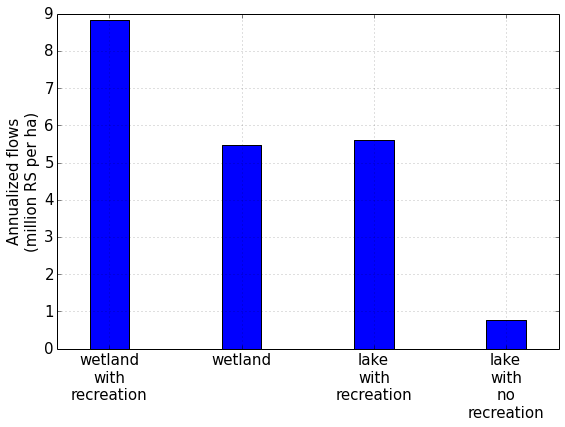

In [54]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

tp = compare.loc["Net value",:]
tp.index = [s.replace(" ","\n") for s in tp.index]

tp.plot(kind='bar',colormap="winter",figsize=(9,6),legend=False,width=0.3)
#plt.legend(frameon=False,bbox_to_anchor=[-0.03,0.5,0.5,0.5],fontsize=15)
plt.xlabel("")
plt.ylabel("Annualized flows\n(million RS per ha)")
plt.xticks(rotation=0)
plt.grid(which='major', alpha=0.5)

plt.savefig("lakes_vs_wetlands",bbox_inches="tight",dpi=400)

In [12]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

compare["Net value"].plot(kind='bar',colormap="winter",figsize=(9,5),legend=False)
plt.legend(frameon=False,bbox_to_anchor=[-0.03,0.5,0.5,0.5],fontsize=15)
plt.xlabel("")
plt.ylabel("Annualized flows\n(million RS per ha)")
plt.xticks(rotation=45)
plt.grid(which='major', alpha=0.5)

plt.title("Wetlands with recreational benefits are more economically sound\nthan lakes even without accounting for flood retention",fontsize=15)

#plt.savefig("lakes_vs_wetlands",bbox_inches="tight",dpi=400)

KeyError: 'Net value'

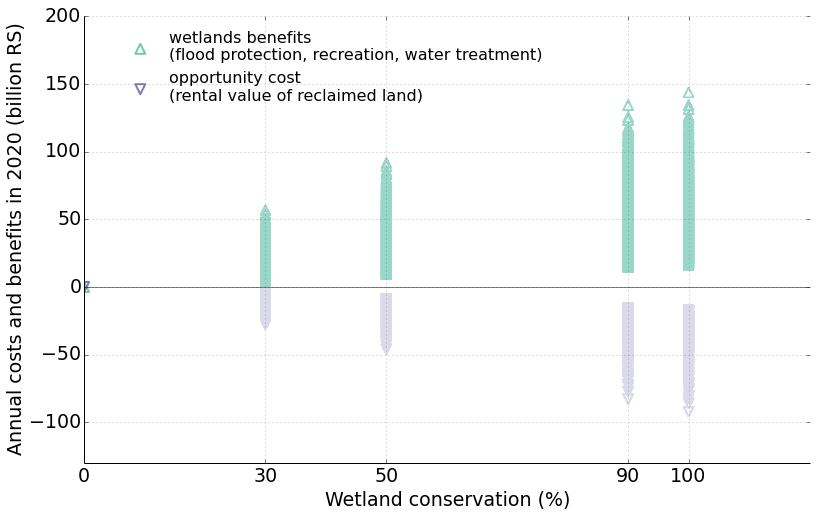

In [282]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change==1)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.9,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.9,\
                label="opportunity cost\n(rental value of reclaimed land)")

ax.legend(bbox_to_anchor=[0.15,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.9)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.9)
        
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.savefig("ppt/min_max_regret_wetlands_0.png",bbox_inches="tight",dpi=400)

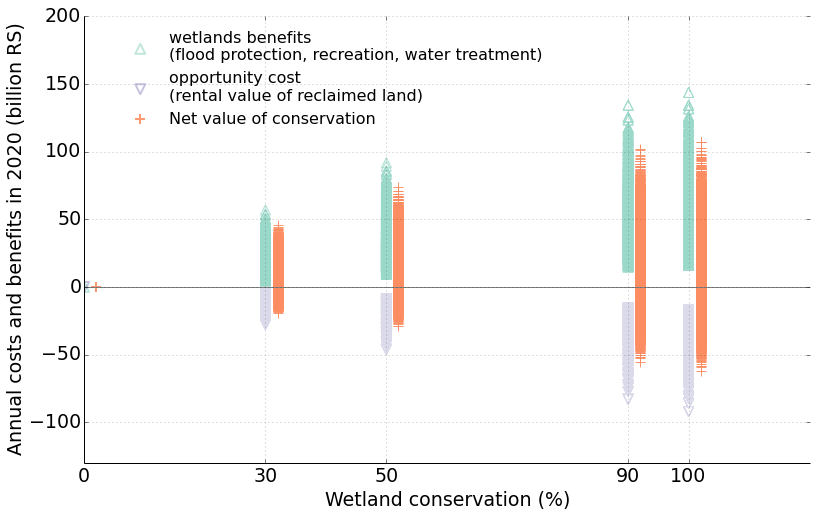

In [286]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change==1)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

plt.scatter(0,0,marker='^',facecolors='none',edgecolors='#66c2a4',linewidth='2',s=100,alpha=0.4,\
                label="wetlands benefits\n(flood protection, recreation, water treatment)")

plt.scatter(0,0,marker='v',facecolors='none',edgecolors='#756bb1',linewidth='2',s=100,alpha=0.4,\
                label="opportunity cost\n(rental value of reclaimed land)")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.15,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)]*len(yb),yb,\
               marker='^',facecolors='none',edgecolors='#99d8c9',linewidth='1',s=100,alpha=0.2)
    plt.scatter([int(name)]*len(yc),-yc,\
               marker='v',facecolors='none',edgecolors='#dadaeb',linewidth='1',s=100,alpha=0.2)
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
       

plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands_1.png",bbox_inches="tight",dpi=400)

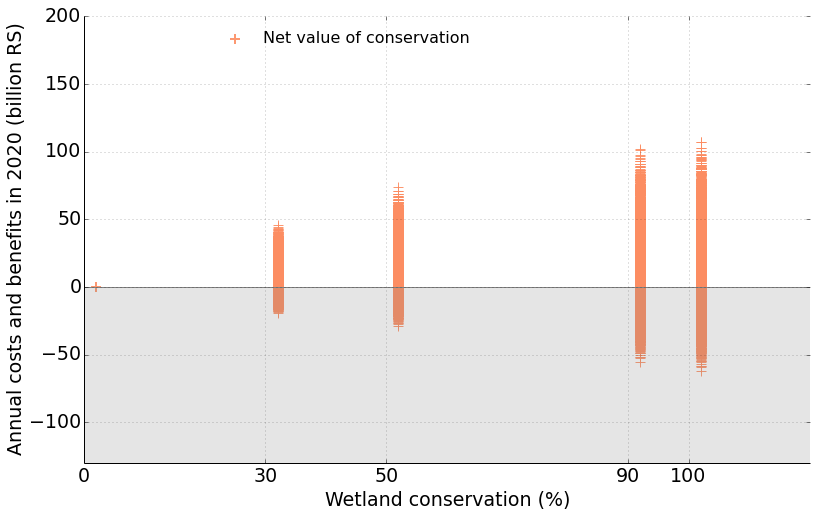

In [292]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change==1)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.05,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)

plt.xticks([0,30,50,90,100])

ax.fill_between([0,120], 0, -130,facecolor='grey',alpha=0.2)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands_2.png",bbox_inches="tight",dpi=400)

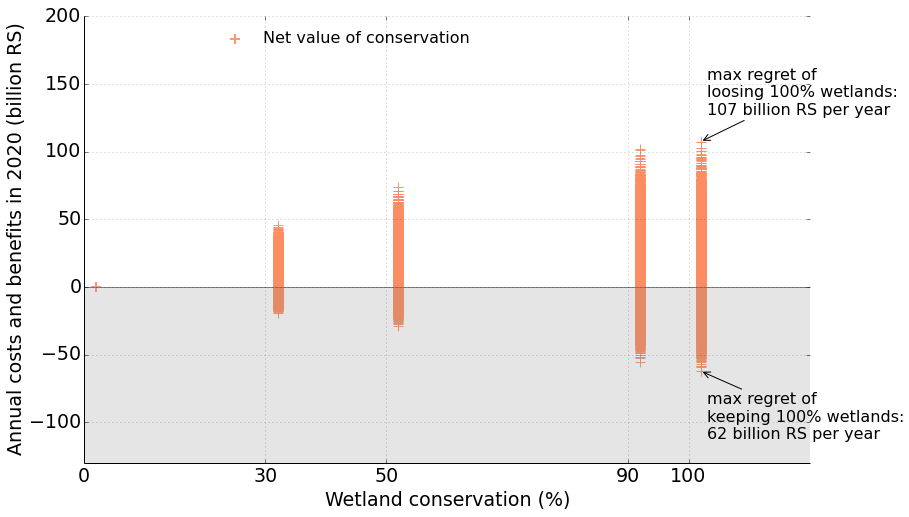

In [291]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

#select = (npv_res.GDPgr==0)&(npv_res.Popgr==0)&(npv_res.urban_policy==0)&(npv_res.climate_change==0)
select = (npv_res.urban_policy<2)&(npv_res.climate_change==1)&(npv_res.option=="wetland with recreation")
grouped = npv_res.ix[select,:].groupby("wetland_preserv")

plt.scatter(2,0,marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='2',s=100,alpha=0.9,\
                label="Net value of conservation")

ax.legend(bbox_to_anchor=[0.05,0.5,0.5,0.5],frameon=False,scatterpoints=1,fontsize=16)

plt.plot([0,120],[0,0],color="grey")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    yc = group.cost
    yb = group.benef
    yn = group.npv
    plt.scatter([int(name)+2]*len(yb),yn,\
               marker='+',facecolors='none',edgecolors='#fc8d62',linewidth='1',s=100,alpha=0.9)
    
    if i==4:
        ax.annotate("max regret of\nkeeping {}% wetlands:\n{} billion RS per year".format(int(name),-np.rint(min(yn))).replace(".0",""),\
                    xy=(int(name)+2,min(yn)), xycoords='data',
                        xytext=(int(name)+3,min(yn)-50), textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"),fontsize=16)
        
        ax.annotate("max regret of\nloosing 100% wetlands:\n{} billion RS per year".format(np.rint(max(yn))).replace(".0",""),
                    xy=(int(name)+2, max(yn)), xycoords='data',
                    xytext=(int(name)+3, max(yn)+20), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                    fontsize=16
                    )

plt.xticks([0,30,50,90,100])

ax.fill_between([0,120], 0, -130,facecolor='grey',alpha=0.2)

ax.grid(which='major', alpha=0.5)
ax.set_xlim([0,120])
ax.set_ylim([-130,200])

plt.ylabel('Annual costs and benefits in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/min_max_regret_wetlands_3.png",bbox_inches="tight",dpi=400)

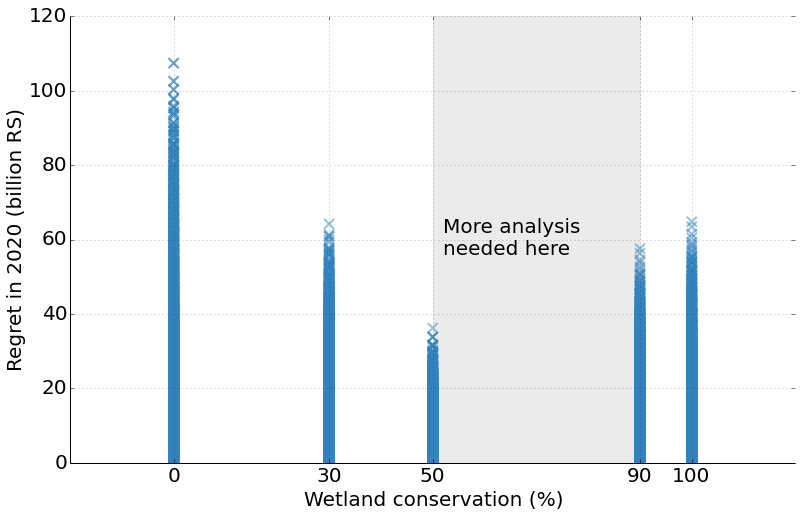

In [293]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(13,8))

ax=plt.subplot(111)

#select = (regret.GDPgr==0)&(regret.Popgr==0)&(regret.urban_policy==0)&(regret.climate_change==0)
select = (regret.option=="wetland with recreation")
select = (regret.urban_policy==0)&(regret.climate_change<2)
grouped = regret.ix[select,:].groupby("wetland_preserv")

ax.fill_between([50,90], 0, 120, color='#d9d9d9', alpha=0.5)

for i, (name, group) in enumerate(grouped):
    y1 = group.ix[group.option=="wetland with recreation","regret"]
    plt.scatter([int(name)]*len(y1),-y1,\
               marker='x',facecolors='none',edgecolors='#3182bd',linewidth='2',s=100,alpha=0.5)
    
plt.xticks([0,30,50,90,100])
#aa = ["{}%".format(i) for i in [0,30,50,90,100]]
#ax.set_xticklabels(aa)

ax.grid(which='major', alpha=0.5)

plt.ylabel('Regret in 2020 (billion RS)')
plt.xlabel('Wetland conservation (%)')

ax.set_ylim([0,120])

plt.annotate("More analysis\nneeded here",xy=(52,56))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("ppt/max_regret_criteria.png",bbox_inches="tight",dpi=400)

In [305]:
(160*10**3*2.3*10**6)*10**(-9)

368.0

In [306]:
5/368

0.01358695652173913